In [1]:
%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import math, gillespy2
from gillespy2.basic_tau_hybrid_solver import BasicTauHybridSolver
from gillespy2.basic_ssa_solver import BasicSSASolver
from gillespy2.optimized_ssa_solver import NumPySSASolver

Using matplotlib backend: Qt5Agg


The performance of this package can be significantly increased if you install Cython.


In [371]:
class DayModel(gillespy2.Model):
    def __init__(self, parameter_values=None, init_v=0):
        # initialize
        gillespy2.Model.__init__(self, name="Macrophage")
        
        # species
        S_ = gillespy2.Species(name='S_', initial_value=1e9)
        #A_ = gillespy2.Species(name='A_', initial_value=0)
        Hi_ = gillespy2.Species(name='Hi_', initial_value=0)
        HLN_ = gillespy2.Species(name='HLN_', initial_value=0)
        E_ = gillespy2.Species(name='E_', initial_value=2e6)
        Be_ = gillespy2.Species(name='Be_', initial_value=0)
        N_ = gillespy2.Species(name='N_', initial_value=0)
        TA_ = gillespy2.Species(name='TA_', initial_value=0)
        
        self.add_species([S_,Hi_,HLN_,E_,Be_,N_,TA_])
        
        # parameters
        ns = gillespy2.Parameter(name='ns', expression=3) # avg = 3.38
        nb = gillespy2.Parameter(name='nb', expression=5)

        k1 = gillespy2.Parameter(name='k1', expression=1e-5)
        k2 = gillespy2.Parameter(name='k2', expression=1e-10)
        k3 = gillespy2.Parameter(name='k3', expression=0.05)
        k4 = gillespy2.Parameter(name='k4', expression=2)
        k5 = gillespy2.Parameter(name='k5', expression=0.8)
        k6 = gillespy2.Parameter(name='k6', expression=5e-10)
        k8 = gillespy2.Parameter(name='k8', expression=6e-10)
        k9 = gillespy2.Parameter(name='k9', expression=5e-10)
        k10 = gillespy2.Parameter(name='k10', expression=1e-5)

        ## these are the only params lower than in Day paper to shorten sim time
        Sa = gillespy2.Parameter(name='Sa', expression=3e6)
        Se = gillespy2.Parameter(name='Se', expression=1e6)

        MuA = gillespy2.Parameter(name='MuA', expression=0.05)
        MuE = gillespy2.Parameter(name='MuE', expression=0.05)
        MuN = gillespy2.Parameter(name='MuN', expression=0.06)
        MuTA = gillespy2.Parameter(name='MuTA', expression=2)

        N0 = gillespy2.Parameter(name='N0', expression=5500)

        BeMAX = gillespy2.Parameter(name='BeMAX', expression=5e11)

        CT1 = gillespy2.Parameter(name='CT1', expression=1)
        CT2 = gillespy2.Parameter(name='CT2', expression=1)
        CT3 = gillespy2.Parameter(name='CT3', expression=1)
        CTB = gillespy2.Parameter(name='CTB', expression=1000)
        
        
        #self.add_parameter([ns,k2,k3,Sa,MuA])
        self.add_parameter([ns,nb,k1,k2,k3,k4,k5,k6,k8,k9,k10,Sa,Se,MuA,MuE,MuN,MuTA,N0,BeMAX,CT1,CT2,CT3,CTB])
        
        # reactions
        R1 = gillespy2.Reaction(
            name='R1',
            reactants={S_:float(ns.expression)},
            products={Hi_:1},
            propensity_function="(k2*S_*(Sa/(k2*S_ + MuA)))/ns"
        )
        
        R2 = gillespy2.Reaction(
            name='R2',
            reactants={Hi_:1},
            products={HLN_:1},
            rate=k3
        )
        
        R3 = gillespy2.Reaction(
            name='R3',
            reactants={},
            products={E_:1},
            rate=Se
        )
        
        R4 = gillespy2.Reaction(
            name='R4',
            reactants={E_:1},
            products={},
            rate=MuE
        )
        
        R5 = gillespy2.Reaction(
            name='R5',
            reactants={E_:1,Be_:1},
            products={},
            rate=k1
        )
        
        R6 = gillespy2.Reaction(
            name='R6',
            reactants={HLN_:1},
            products={Be_:float(nb.expression)},
            rate=k3
        )
        
        R7 = gillespy2.Reaction(
            name='R7',
            reactants={Be_:1},
            products={Be_:1},
            propensity_function="k5*Be_*(1 - (Be_/BeMAX))"
        )
        
        R8 = gillespy2.Reaction(
            name='R8',
            reactants={E_:1,Be_:1},
            products={},
            rate=k6
        )
        
        R9 = gillespy2.Reaction(
            name='R9',
            reactants={N_:1,Be_:1},
            products={},
            propensity_function="(k8*N_*Be_)/(1+(TA_/CT1))"
        )
        
        R10 = gillespy2.Reaction(
            name='R10',
            reactants={Be_:1,E_:1},
            products={N_:1},
            propensity_function="(k9*Be_*E_*N0)/(1+(TA_/CT2))"
        )
        
        R11 = gillespy2.Reaction(
            name='R11',
            reactants={N_:1},
            products={N_:1},
            propensity_function="(k10*N_*N0)/(1+(TA_/CT3))"
        )
        
        R12 = gillespy2.Reaction(
            name='R12',
            reactants={N_:1},
            products={},
            rate=MuN
        )
        
        R13 = gillespy2.Reaction(
            name='R13',
            reactants={Be_:1},
            products={TA_:1},
            propensity_function="k4*(Be_/(CTB+Be_))"
        )
        
        R14 = gillespy2.Reaction(
            name='R14',
            reactants={TA_:1},
            products={},
            rate=MuTA
        )
                
        self.add_reaction([R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14])
        t = numpy.linspace(0,200,401)
        self.timespan(t)
        print(t)

In [372]:
model = DayModel()

[   0.     0.5    1.     1.5    2.     2.5    3.     3.5    4.     4.5
    5.     5.5    6.     6.5    7.     7.5    8.     8.5    9.     9.5
   10.    10.5   11.    11.5   12.    12.5   13.    13.5   14.    14.5
   15.    15.5   16.    16.5   17.    17.5   18.    18.5   19.    19.5
   20.    20.5   21.    21.5   22.    22.5   23.    23.5   24.    24.5
   25.    25.5   26.    26.5   27.    27.5   28.    28.5   29.    29.5
   30.    30.5   31.    31.5   32.    32.5   33.    33.5   34.    34.5
   35.    35.5   36.    36.5   37.    37.5   38.    38.5   39.    39.5
   40.    40.5   41.    41.5   42.    42.5   43.    43.5   44.    44.5
   45.    45.5   46.    46.5   47.    47.5   48.    48.5   49.    49.5
   50.    50.5   51.    51.5   52.    52.5   53.    53.5   54.    54.5
   55.    55.5   56.    56.5   57.    57.5   58.    58.5   59.    59.5
   60.    60.5   61.    61.5   62.    62.5   63.    63.5   64.    64.5
   65.    65.5   66.    66.5   67.    67.5   68.    68.5   69.    69.5
   70.

In [373]:
%time results = model.run(solver=NumPySSASolver())

Wall time: 5d 14h 59min


Spores remaining: 630595567.0
Intralung host cells: 11411777.0


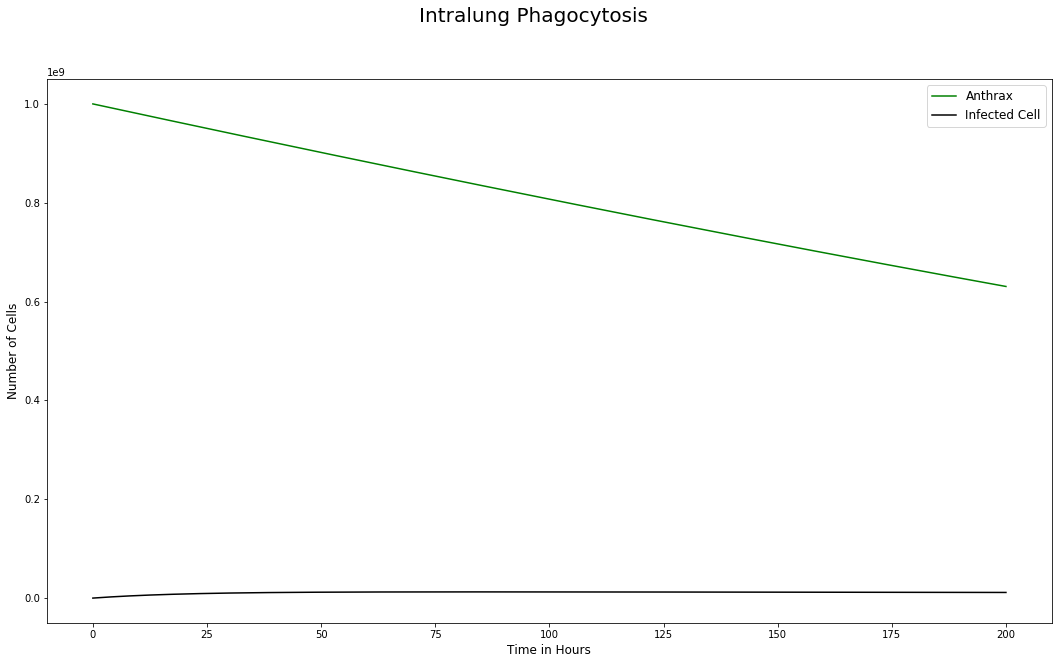

In [374]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Intralung Phagocytosis", fontsize=20)
plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Anthrax')
#plt.plot(results['time'], results['M_'], 'b-', label='Macrophage')
plt.plot(results[0]['time'], results[0]['Hi_'], 'k-', label='Infected Cell')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Spores remaining: {}".format(results[0]['S_'][-1]))
print("Intralung host cells: {}".format(results[0]['Hi_'][-1]))




Host Cells in Lung: 11411777.0
Host Cells in TMLN: 11644179.0


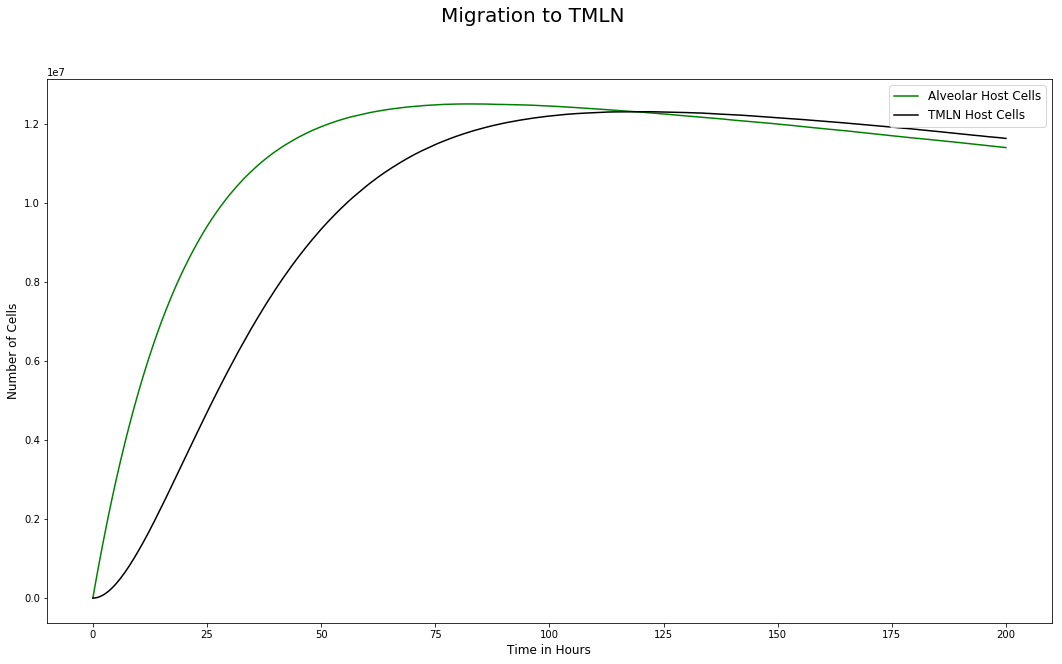

In [375]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)
#plt.plot(results[0]['time'], results[0]['S_'], 'k-', label='Spores')
plt.plot(results[0]['time'], results[0]['Hi_'], 'g-', label='Alveolar Host Cells')
plt.plot(results[0]['time'], results[0]['HLN_'], 'k-', label='TMLN Host Cells')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
print("Host Cells in Lung: {}".format(results[0]['Hi_'][-1]))
print("Host Cells in TMLN: {}".format(results[0]['HLN_'][-1]))


Lymphocyte Cells: 280.0


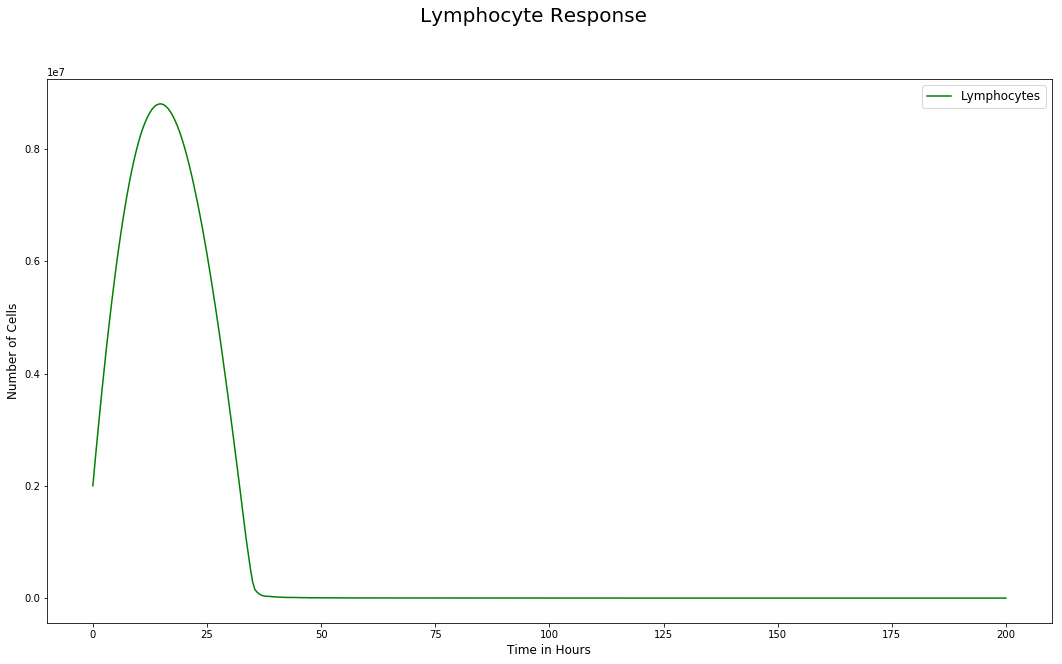

In [376]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Lymphocyte Response", fontsize=20)
plt.plot(results[0]['time'], results[0]['E_'], 'g-', label='Lymphocytes')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Lymphocyte Cells: {}".format(results[0]['E_'][-1]))

Extracellular Cells: 297568246.0


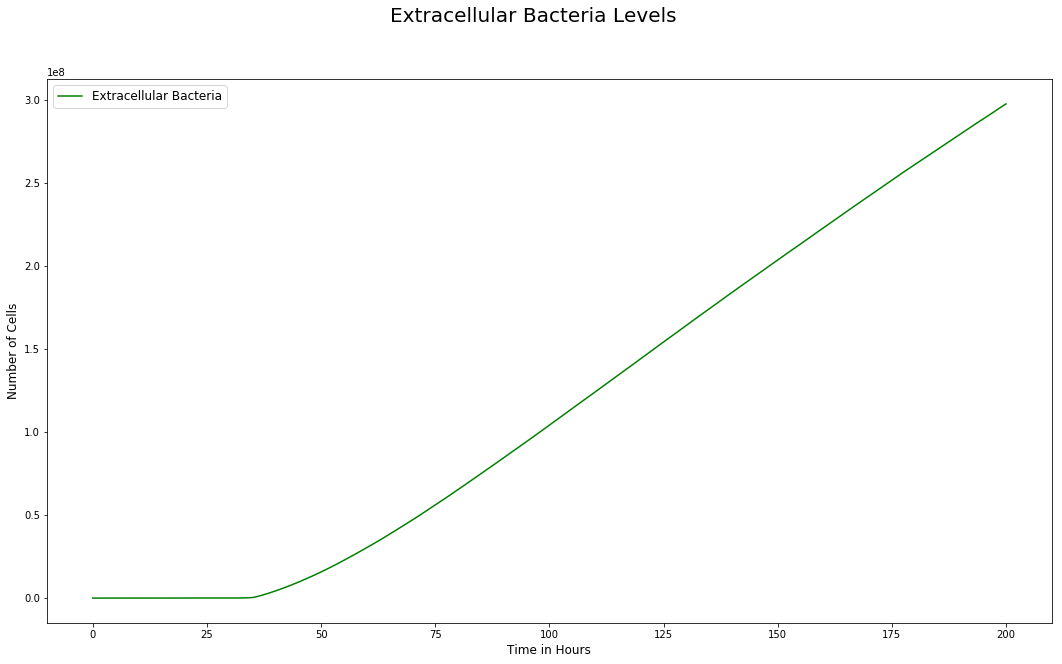

In [377]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Extracellular Bacteria Levels", fontsize=20)
plt.plot(results[0]['time'], results[0]['Be_'], 'g-', label='Extracellular Bacteria')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Extracellular Cells: {}".format(results[0]['Be_'][-1]))

Lymphocyte Cells: 867429.0


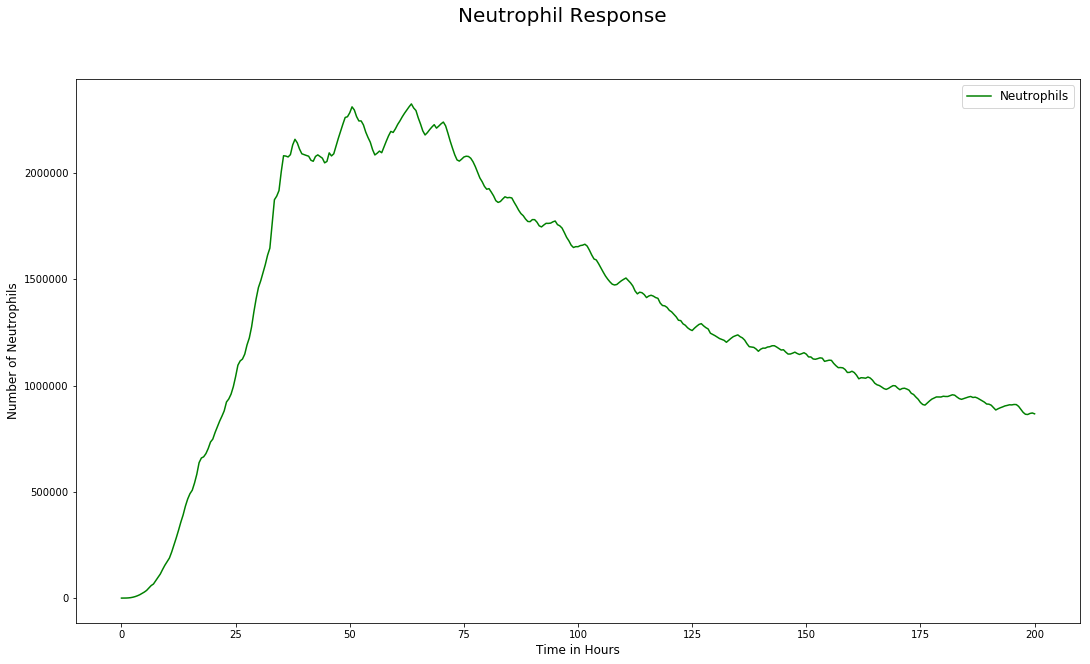

In [378]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Neutrophil Response", fontsize=20)
plt.plot(results[0]['time'], results[0]['N_'], 'g-', label='Neutrophils')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Neutrophils", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Lymphocyte Cells: {}".format(results[0]['N_'][-1]))

Toxins: 1.0


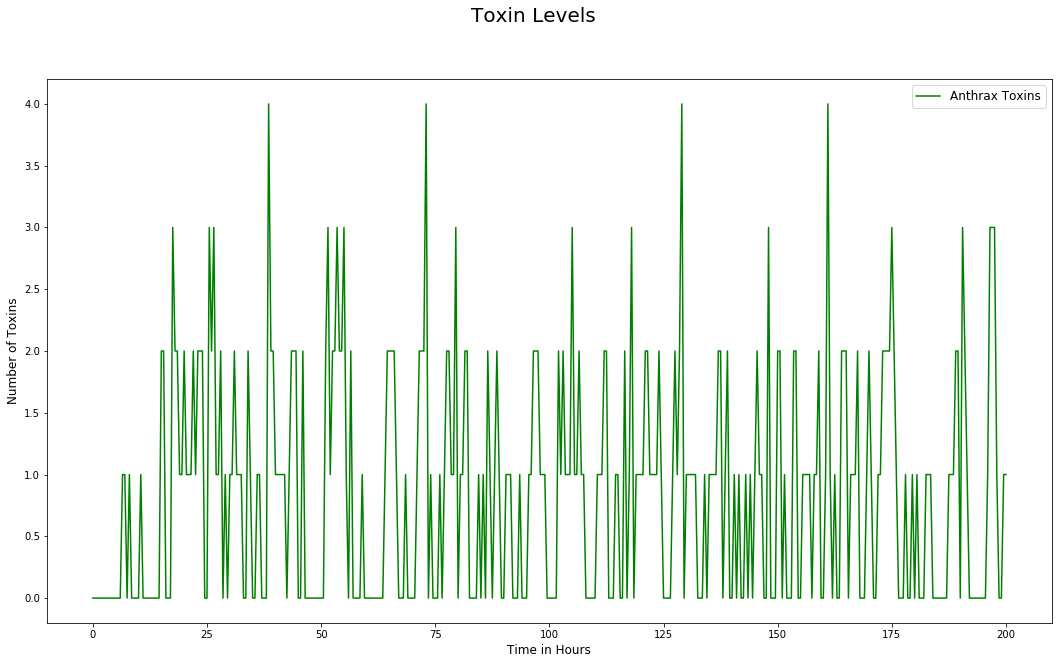

In [379]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Toxin Levels", fontsize=20)
plt.plot(results[0]['time'], results[0]['TA_'], 'g-', label='Anthrax Toxins')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Toxins", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Toxins: {}".format(results[0]['TA_'][-1]))